<a href="https://colab.research.google.com/github/rlawogjs96/Kaggle/blob/main/How_well_do_our_smartphones_know_about_us%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What do our smartphones know about us? 
This notebook is to extract as much information as possible about a smartphone user. 

Import Libraries

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pwd
%cd ./gdrive/MyDrive/Smartphone

/content
/content/gdrive/MyDrive/Smartphone


In [4]:
# Store data 
import pandas as pd
import os 

# Linear Algebra 
import numpy as np 
from numpy import pi 

# To celebrate plots 
from matplotlib.colors import rgb2hex 
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt 

# Create nicer plots 
import seaborn as sns 

# To create interactive plots 
from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go 
init_notebook_mode(connected = True)

# To get new datatypes and functions 
from collections import Counter
from cycler import cycler 

# To investigate distributions 
from scipy.stats import norm, skew, probplot 
from scipy.optimize import curve_fit 

# To build new models 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE 

# To gbm light 
from lightgbm import LGBMClassifier

# To measure time 
from time import time

# Load data

In [5]:
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv') 

# Combine both dataframes 
train_df['Data'] = 'Train'
test_df['Data'] = 'Test'
both_df = pd.concat([train_df, test_df], axis = 0).reset_index(drop=True) 
both_df['subject'] = '#' + both_df['subject'].astype(str)

# Create label
label = both_df.pop('Activity') 

print(f'Shape of Training Data: {train_df.shape}')
print(f'Shape of Test Data: {test_df.shape}')

train_df.head() 

Shape of Training Data: (7352, 564)
Shape of Test Data: (2947, 564)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,Data
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING,Train
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING,Train
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING,Train
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING,Train
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING,Train


The directors of the study created a vast number of features just using simply two sensors.

# Dataset Exploration 

### Which features are there? 
The features seem to have a main name and some information on how they have been computed attached. Grouping the main names will reduce the dimensions for the first impression.

In [6]:
# Group and count main names of columns 
pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in both_df.columns]), orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)

,count
fBodyAcc,79
fBodyGyro,79
fBodyAccJerk,79
tGravityAcc,40
tBodyAcc,40
tBodyGyroJerk,40
tBodyGyro,40
tBodyAccJerk,40
tBodyAccMag,13
tGravityAccMag,13


Mainly there are 'acceleration' and 'gyroscope' features. A few 'gravity' features are there as well.

Impressive how many features there are in regard of the limited number of sensors used.

### **What Types of Data Are There?**

In [7]:
# Find null values and dataframe information
print(f'Null Values In DataFrame: {both_df.isna().sum().sum()}')
both_df.info()

Null Values In DataFrame: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 563 entries, tBodyAcc-mean()-X to Data
dtypes: float64(561), object(2)
memory usage: 44.2+ MB


Except from the label and the newly created 'Data' and 'subject' features there is only numerical data. Fortunately there are no missing values.



### **How are the Labels Distributed?**

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



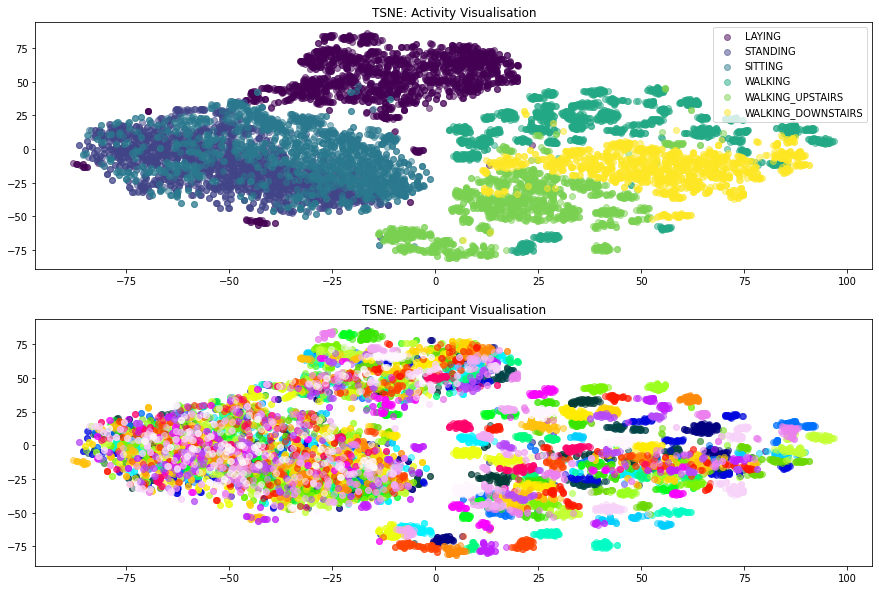

In [9]:
# Create datasets
tsne_data = both_df.copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions (speed up)
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)


# Create subplots
fig, axarr = plt.subplots(2, 1, figsize=(15,10))

### Plot Activities
# Get colors
n = label.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (label==group).values
    axarr[0].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr[0].set_title('TSNE: Activity Visualisation')
axarr[0].legend()


### Plot Subjects
# Get colors
n = subject_data.unique().shape[0]
colormap = get_cmap('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each participant
for i, group in enumerate(subject_data.unique()):
    # Mask to separate sets
    mask = (subject_data==group).values
    axarr[1].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)

axarr[1].set_title('TSNE: Participant Visualisation')
plt.show()

In [10]:
# Split training testing data
enc = LabelEncoder()
label_encoded = enc.fit_transform(label)
X_train, X_test, y_train, y_test = train_test_split(tsne_data, label_encoded, random_state=3)

# Create the model
lgbm = LGBMClassifier(n_estimators=500, random_state=3)
lgbm = lgbm.fit(X_train, y_train)

# Test the model
score = accuracy_score(y_true=y_test, y_pred=lgbm.predict(X_test))
print('Accuracy on testset:\t{:.4f}\n'.format(score))

Accuracy on testset:	0.9553



In [ ]:
# Store the data
data = []
# Iterate over each activity
for activity in label_counts.index:
    # Create dataset
    act_data = both_df[label==activity].copy()
    act_data_data = act_data.pop('Data')
    act_subject_data = act_data.pop('subject')
    
    # Scale data
    scl = StandardScaler()
    act_data = scl.fit_transform(act_data)

    # Reduce dimensions
    pca = PCA(n_components=0.9, random_state=3)
    act_data = pca.fit_transform(act_data)

    
    # Split training testing data
    enc = LabelEncoder()
    label_encoded = enc.fit_transform(act_subject_data)
    X_train, X_test, y_train, y_test = train_test_split(act_data, label_encoded, random_state=3)


    # Fit basic model
    print('Activity: {}'.format(activity))
    lgbm = LGBMClassifier(n_estimators=500, random_state=3)
    lgbm = lgbm.fit(X_train, y_train)
    
    score = accuracy_score(y_true=y_test, y_pred=lgbm.predict(X_test))
    print('Accuracy on testset:\t{:.4f}\n'.format(score))
    data.append([activity, score])

Activity: LAYING
Accuracy on testset:	0.6481

Activity: STANDING
Accuracy on testset:	0.5493

Activity: SITTING
Accuracy on testset:	0.5303

Activity: WALKING
Accuracy on testset:	0.9513

Activity: WALKING_UPSTAIRS
Accuracy on testset:	0.9249

Activity: WALKING_DOWNSTAIRS
Accuracy on testset:	0.9091



In [ ]:
# Create duration datafrae
duration_df = (both_df.groupby([label, subject_data])['Data'].count().reset_index().groupby('Activity').agg({'Data':'mean'}) * 1.28).rename(columns={'Data':'Seconds'})
activity_df = pd.DataFrame(data, columns=['Activity', 'Accuracy']).set_index('Activity')
activity_df.join(duration_df)

,Accuracy,Seconds
Activity,,
LAYING,0.648148,82.944000
STANDING,0.549266,81.322667
SITTING,0.530337,75.818667
WALKING,0.951276,73.472000
WALKING_UPSTAIRS,0.924870,65.877333
WALKING_DOWNSTAIRS,0.909091,59.989333


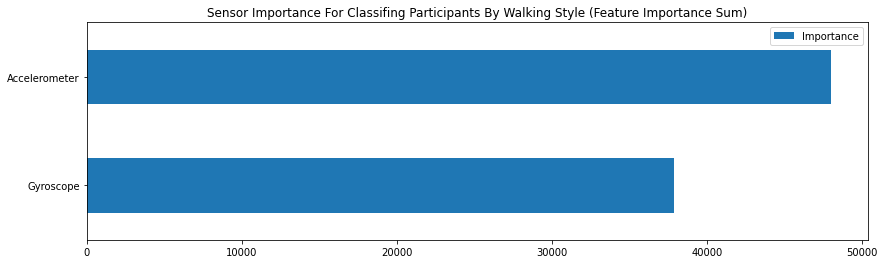

In [ ]:
# Create dataset
tsne_data = both_df[label=='WALKING'].copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Split training testing data
enc = LabelEncoder()
label_encoded = enc.fit_transform(subject_data)
X_train, X_test, y_train, y_test = train_test_split(tsne_data, label_encoded, random_state=3)


# Create model
lgbm = LGBMClassifier(n_estimators=500, random_state=3)
lgbm = lgbm.fit(X_train, y_train)

# Get importances
features = both_df.drop(['Data', 'subject'], axis=1).columns
importances = lgbm.feature_importances_

# Sum importances
data = {'Gyroscope':0, 'Accelerometer':0}
for importance, feature in zip(importances, features):
    if 'Gyro' in feature:
        data['Gyroscope'] += importance
    if 'Acc' in feature:
        data['Accelerometer'] += importance
        
# Create dataframe and plot
sensor_df = pd.DataFrame.from_dict(data, orient='index').rename(columns={0:'Importance'})
sensor_df.plot(kind='barh', figsize=(14,4), title='Sensor Importance For Classifing Participants By Walking Style (Feature Importance Sum)')
plt.show()

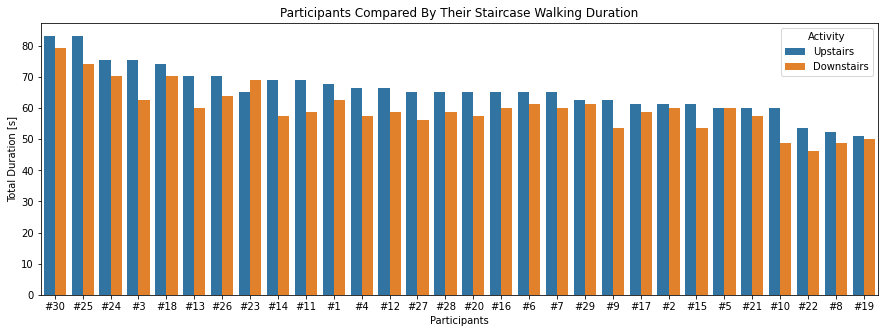

In [12]:
# Group the data by participant and compute total duration of staircase walking
mask = label.isin(['WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])
duration_df = (both_df[mask].groupby([label[mask], 'subject'])['Data'].count() * 1.28)

# Create plot
plot_data = duration_df.reset_index().sort_values('Data', ascending=False)
plot_data['Activity'] = plot_data['Activity'].map({'WALKING_UPSTAIRS':'Upstairs', 'WALKING_DOWNSTAIRS':'Downstairs'})

plt.figure(figsize=(15,5))
sns.barplot(data=plot_data, x='subject', y='Data', hue='Activity')
plt.title('Participants Compared By Their Staircase Walking Duration')
plt.xlabel('Participants')
plt.ylabel('Total Duration [s]')
plt.show()

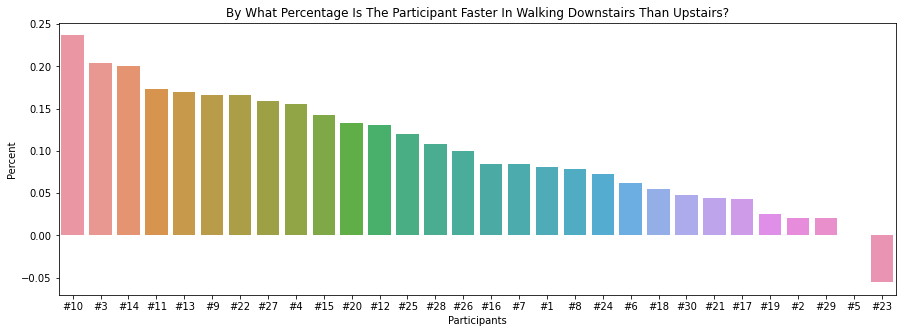

In [13]:
# Create data and plot
plt.figure(figsize=(15,5))
plot_data = ((duration_df.loc['WALKING_UPSTAIRS'] / duration_df.loc['WALKING_DOWNSTAIRS']) -1).sort_values(ascending=False)
sns.barplot(x=plot_data.index, y=plot_data)
plt.title('By What Percentage Is The Participant Faster In Walking Downstairs Than Upstairs?')
plt.xlabel('Participants')
plt.ylabel('Percent')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/li

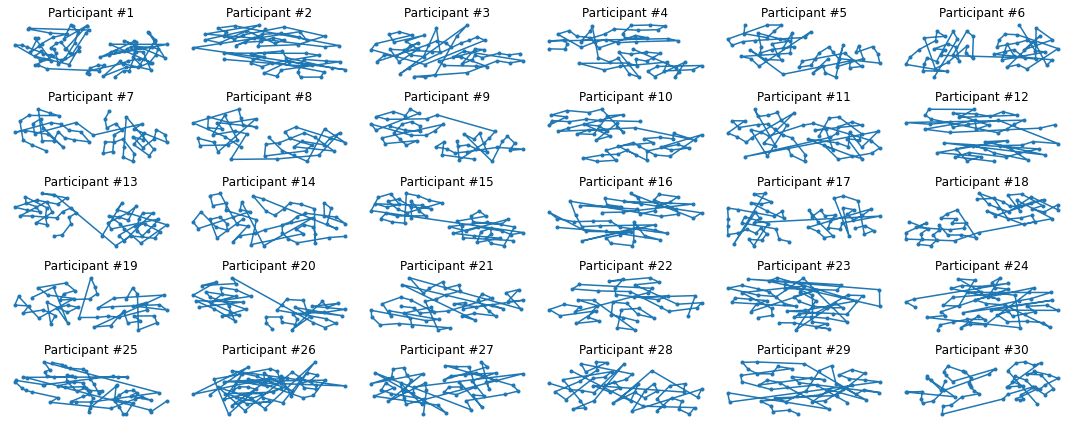

In [ ]:
fig, axarr = plt.subplots(5, 6, figsize=(15,6))

for person in range(0, 30):
    # Get data
    single_person = both_df[(label=='WALKING') & (both_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)
    # Scale data
    scl = StandardScaler()
    tsne_data = scl.fit_transform(single_person)
    # Reduce dimensions
    pca = PCA(n_components=0.9, random_state=3)
    tsne_data = pca.fit_transform(tsne_data)
    # Transform data
    tsne = TSNE(random_state=3)
    tsne_transformed = tsne.fit_transform(tsne_data)
    
    # Create plot
    axarr[person//6][person%6].plot(tsne_transformed[:,0], tsne_transformed[:,1], '.-')
    axarr[person//6][person%6].set_title('Participant #{}'.format(person+1))
    axarr[person//6][person%6].axis('off')
    
plt.tight_layout()
plt.show()

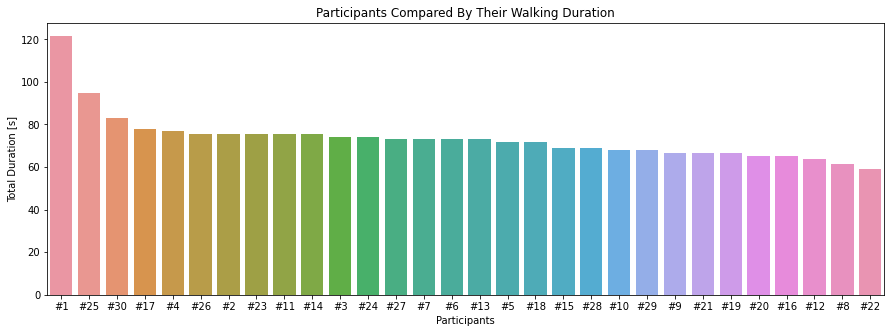

In [ ]:
# Group the data by participant and compute total duration of walking
mask = label=='WALKING'
duration_df = (both_df[mask].groupby('subject')['Data'].count() * 1.28)

# Create plot
plot_data = duration_df.reset_index().sort_values('Data', ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(data=plot_data, x='subject', y='Data')
plt.title('Participants Compared By Their Walking Duration')
plt.xlabel('Participants')
plt.ylabel('Total Duration [s]')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/li

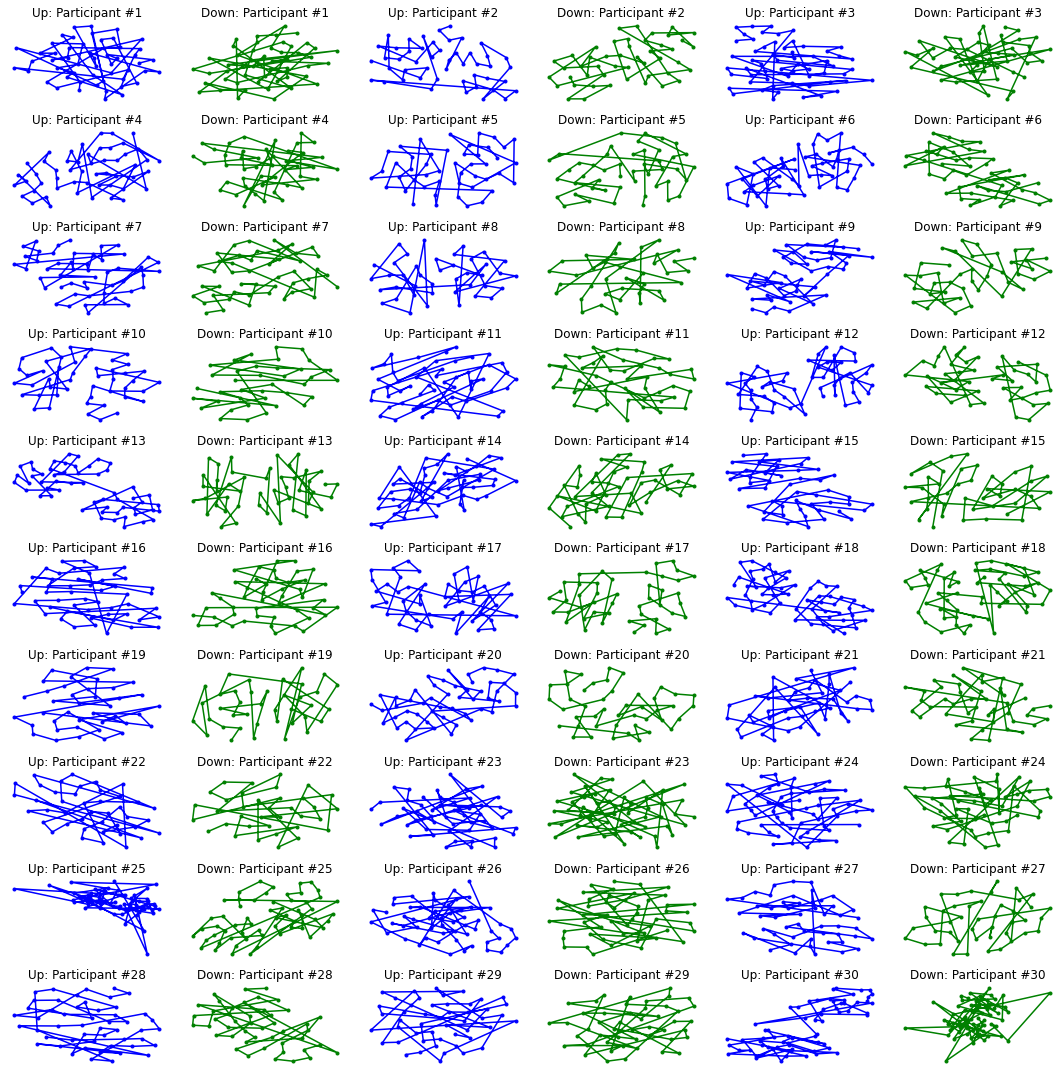

In [14]:
# Create subplots
fig, axarr = plt.subplots(10, 6, figsize=(15,15))

# Iterate over each participant
for person in range(0, 30):
    # Get data
    single_person_up = both_df[(label=='WALKING_UPSTAIRS') & (both_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)
    single_person_down = both_df[(label=='WALKING_DOWNSTAIRS') & (both_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)
    # Scale data
    scl = StandardScaler()
    tsne_data_up = scl.fit_transform(single_person_up)
    tsne_data_down = scl.fit_transform(single_person_down)
    # Reduce dimensions
    pca = PCA(n_components=0.9, random_state=3)
    tsne_data_up = pca.fit_transform(tsne_data_up)
    tsne_data_down = pca.fit_transform(tsne_data_down)
    # Transform data
    tsne = TSNE(random_state=3)
    tsne_transformed_up = tsne.fit_transform(tsne_data_up)
    tsne_transformed_down = tsne.fit_transform(tsne_data_down)
    
    # Create plot
    axarr[2*person//6][2*person%6].plot(tsne_transformed_up[:,0], tsne_transformed_up[:,1], '.b-')
    axarr[2*person//6][2*person%6].set_title('Up: Participant #{}'.format(person+1))
    axarr[2*person//6][2*person%6].axis('off')
    axarr[2*person//6][(2*person%6)+1].plot(tsne_transformed_down[:,0], tsne_transformed_down[:,1], '.g-')
    axarr[2*person//6][(2*person%6)+1].set_title('Down: Participant #{}'.format(person+1))
    axarr[2*person//6][(2*person%6)+1].axis('off')
    
plt.tight_layout()
plt.show()